**Лабораторная работа 3**

Выберите временной ряд цен акций.
Подготовьте данные для обучения моделей машинного обучения (нормализация, создание признаков).
Разделите данные на обучающую и тестовую выборки. Реализуйте и обучите следующие модели: a) Логистическая регрессия b) Машина опорных векторов c) Модель случайного леса (Random Forest) d) Градиентный бустинг (например, XGBoost) Настройте гиперпараметры моделей с помощью кросс-валидации. Сделайте прогноз на тестовой выборке для каждой модели. Сравните результаты прогнозирования моделей между собой и с простыми методами (например, наивный прогноз). Визуализируйте результаты прогнозирования. Проанализируйте важность признаков для моделей, где это применимо. Сделайте выводы о эффективности различных подходов машинного обучения в прогнозировании цен акций.

Импортируем необходимые библиотеки



In [2]:
!pip install scikit-learn==1.5.2
!pip install -U --pre xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import yfinance as yf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


Загрузим данные

In [3]:
def load_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data['Close']
orcl = load_data('ORCL', '2022-01-01', '2023-12-31')


[*********************100%***********************]  1 of 1 completed


Создадим функцию для разделения данных на настоящее и будущее



In [4]:
def create_features(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back),0])
        y.append(data[i + look_back,0])
    return np.array(X), np.array(y)

Нормализуем данные

In [5]:
scaler = MinMaxScaler()
orcl_scaled = scaler.fit_transform(orcl.values.reshape(-1, 1))
print(orcl_scaled.shape)

(501, 1)


Разделим данные на тренировочную и тестовую выборки

In [12]:
X, y = create_features(orcl_scaled)
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

(441, 60) (441,)


**Логистическая регрессия**

Найдём лучшие гиперпараметры



In [7]:
y_direction = (y_train > np.roll(y_train, 1))[1:].astype(int)
X_train_lr = X_train[1:]

lr_classifier = LogisticRegression(random_state=42)

lr_params={
    "tol":[0.00001,0.0001,0.001],
    "solver":['lbfgs','liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
lr_grid = GridSearchCV(lr_classifier, lr_params, cv=5, n_jobs=-1,verbose=3)
lr_grid.fit(X_train_lr, y_direction)
best_lr_params = lr_grid.best_params_
print(best_lr_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'solver': 'liblinear', 'tol': 1e-05}


Натренируем модель с лучшими гиперпараметрами



In [8]:
lr_model = LogisticRegression(**best_lr_params,random_state=42)
lr_model.fit(X_train_lr, y_direction)

LogisticRegression(random_state=42, solver='liblinear', tol=1e-05)

**Машина опорных векторов (SVM)**

Найдем наилучшие параметры




In [9]:
svm_classifier = SVR()

svm_params={
    "kernel":['linear', 'poly', 'rbf', 'sigmoid'],
    "degree":[1,3,5,7],
    "gamma": ['scale','auto'],
    "tol":[0.00001,0.0001,0.001]
}
svm_grid = GridSearchCV(svm_classifier, svm_params, cv=5, n_jobs=-1,verbose=3)
svm_grid.fit(X_train, y_train.ravel())
best_svm_params = svm_grid.best_params_
best_svm_params

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'degree': 1, 'gamma': 'scale', 'kernel': 'poly', 'tol': 0.001}

Натренируем модель с лучшими гиперпараметрами


In [10]:
svm_model = SVR(**best_svm_params)
svm_model.fit(X_train, y_train.ravel())

SVR(degree=1, kernel='poly')

**Random Forest**

Найдём лучшие гиперпараметры

In [11]:
rf_classifier = RandomForestRegressor()

rf_params={
    "n_estimators":[10,100,1000],
    "criterion":['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    "max_depth":[1,10,100]
}
rf_grid = GridSearchCV(rf_classifier, rf_params, cv=5, n_jobs=-1,verbose=3)
rf_grid.fit(X_train, y_train.ravel())
best_rf_params = rf_grid.best_params_
best_rf_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'absolute_error', 'max_depth': 100, 'n_estimators': 100}

Натренируем модель с лучшими гиперпараметрами



In [13]:
rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=100,
                      random_state=42)

**XGBoost**

Найдём лучшие гиперпараметры



In [14]:
xgb_classifier = XGBRegressor()

xgb_params={
    "n_estimators":[10,100,1000],
    "learning_rate":[1,0.1,0.01,0.001],
    "max_depth":[1,10,100]
}
xgb_grid = GridSearchCV(xgb_classifier, xgb_params, cv=5, n_jobs=-1,verbose=3)
xgb_grid.fit(X_train, y_train.ravel())
best_xgb_params = xgb_grid.best_params_
best_xgb_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 1000}

Натренируем модель с лучшими гиперпараметрами

In [15]:
xgb_model = XGBRegressor(**best_xgb_params, random_state=42)
xgb_model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Создадим функцию для оценки лубой модели

In [16]:
def evaluate_model(model, X_test, y_test, model_name):
    if model_name == 'Logistic Regression':
        # Для логистической регрессии прогнозируем направление движения
        y_pred_direction = model.predict(X_test)
        y_pred = np.where(y_pred_direction == 1, y_test + 0.01, y_test - 0.01)
    else:
        y_pred = model.predict(X_test).reshape(-1, 1)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    return y_pred

Сравним результаты оценки разных моделей

In [17]:
lr_pred = evaluate_model(lr_model, X_test, y_test, 'Logistic Regression')
svm_pred = evaluate_model(svm_model, X_test, y_test, 'SVM')
rf_pred = evaluate_model(rf_model, X_test, y_test, 'Random Forest')
xgb_pred = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')

Logistic Regression - MAE: 0.0100, RMSE: 0.0100
SVM - MAE: 0.0565, RMSE: 0.0673
Random Forest - MAE: 0.0916, RMSE: 0.1111
XGBoost - MAE: 0.0822, RMSE: 0.1034


**Визуализация результатов**

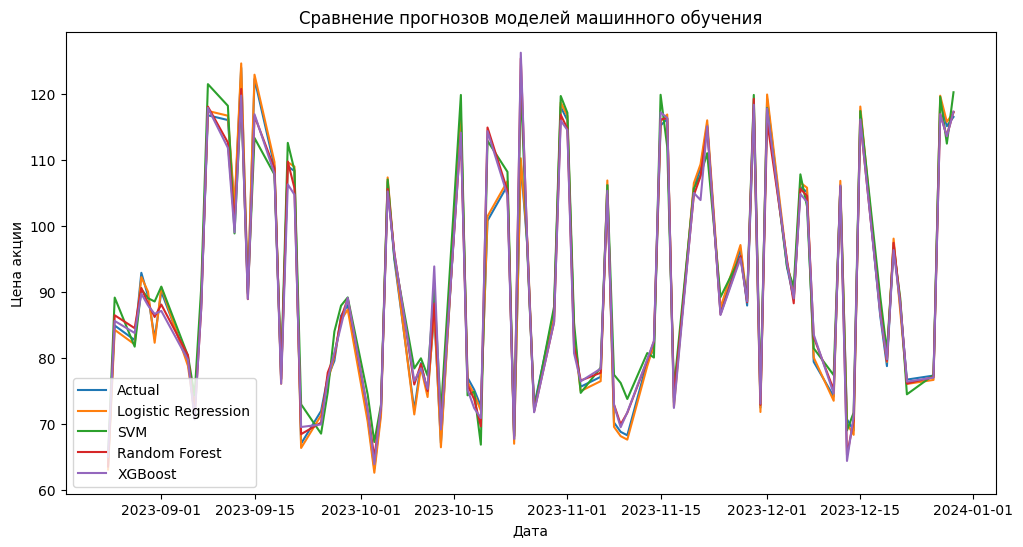

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(orcl.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(orcl.index[-len(y_test):], scaler.inverse_transform(lr_pred.reshape(-1, 1)), label='Logistic Regression')
plt.plot(orcl.index[-len(y_test):], scaler.inverse_transform(svm_pred.reshape(-1, 1)), label='SVM')
plt.plot(orcl.index[-len(y_test):], scaler.inverse_transform(rf_pred.reshape(-1, 1)), label='Random Forest')
plt.plot(orcl.index[-len(y_test):], scaler.inverse_transform(xgb_pred.reshape(-1, 1)), label='XGBoost')
plt.title('Сравнение прогнозов моделей машинного обучения')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.show()

На основе полученного графика можно сказать, что лучше всего справилась модель логистической регрессии, а хуже всего SVM, остальные модели сделали прогноз примерно одного уровня

**Анализ важности признаков для Random Forest**

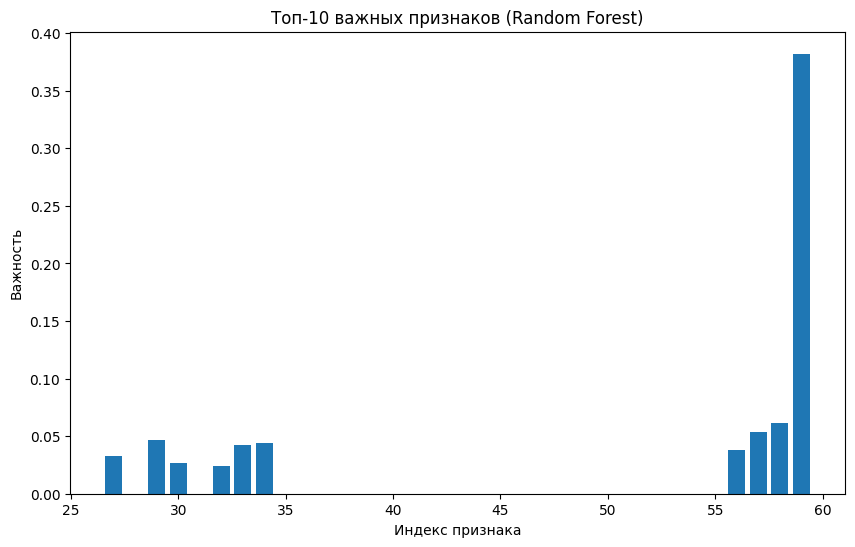

In [18]:
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Топ-10 важных признаков (Random Forest)')
plt.xlabel('Индекс признака')
plt.ylabel('Важность')
plt.show()